# Simulation-Based Inference Hands-On Tutorial

## Source

Adpated from: https://colab.research.google.com/github/smsharma/sbi-lecture-mit/blob/main/tutorial.ipynb#scrollTo=x4x8BGmiwbSS

In [ ]:
! pip install --upgrade emcee corner pytorch-lightning tqdm nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from scipy.stats import poisson
import emcee
import corner

# 1. Introduction

In many scientific problems, we aim to learn about the parameters of a model based on observed data. This process is known as **inference**, and at its core lies the **likelihood function**, $p(x|\theta)$, which quantifies how probable the observed data $x$ is, given a set of model parameters $\theta$.

When models are simple and mathematically well-behaved, the **likelihood function** is known and **tractable**, i.e., we can compute it. However,  in many real-world applications, especially those involving complex simulations or stochastic processes, the likelihood function becomes intractable or expensive to evaluate. While we can still generate simulated data for different parameter values, we can no longer evaluate the likelihood directly.

This tutorial explores how to perform inference in such cases using **Simulation-Based Inference (SBI)** methods. You will:

*   Start with a simple example where inference is straightforward;
*   Understand what makes a likelihood intractable, and when SBI becomes necessary;
* Explore classical approaches to likelihood-free inference: **Template histograms** and **Approximate Bayesian Computation (ABC)**;
* Delve into two widely used modern neural SBI methods: **neural likelihood-ratio estimation (NRE)** and **neural posterior estimation (NPE)**.

These steps will guide you through the main ideas and practical tools behind SBI.



"<img src="https://raw.githubusercontent.com/smsharma/sbi-lecture-mit/main/assets/likelihood.png" width="800">
"<img src="https://raw.githubusercontent.com/smsharma/sbi-lecture-mit/main/assets/sbi.png" width="800">



# 2. Classical Inference with a tractable likelihood: Bump-on-power-law



In high-energy physics, a common way to look for new physics or new particles is to search for a bump in histograms of a kinematic variable. A famous example is the Higgs boson, which appears as a peak in the diphoton invariant mass spectrum.

To build intuition for simulation-based inference (SBI), we will study a simplified version of this problem using synthetic data:

* A **Gaussian signal**: $x_s = A_s\,\exp^{-(y - \mu_s)^2 / 2\sigma_s^2}$, where $A_s$ is the amplitude of the signal, $\mu_s$ the mean location and $\sigma_s$ the standard deviation

* A **power-law background**: $x_b = A_b\,y^{n_b}$, where $A_b$ is the amplitude of the background and $n_b$ the power-law exponent

The total **expected number of events** at each value of some observable $y$ is given by:
$$
x_{\text{expected}}(y) = x_s(y) + x_b(y)
$$

To simulate realistic data, we assume the observed counts in each bin follow a **Poisson distribution**:
$$
x(y) \sim \mathrm{Poisson}(x_{\text{expected}}(y))
$$



In [ ]:
def bump_on_power_law(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

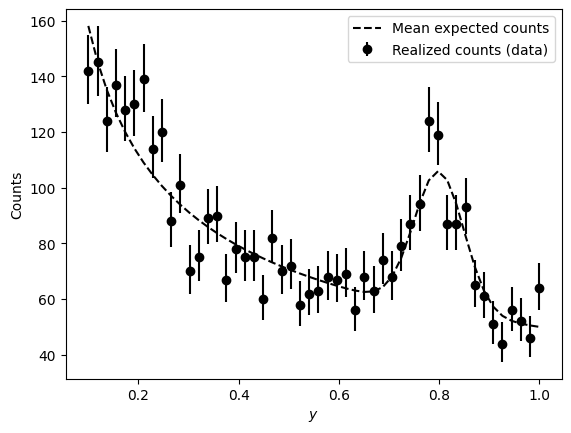

In [ ]:
def poisson_error_interval(k, alpha=0.32):
    """ Calculates Poission error bars for a count value k using chi2 (alpha=0.32 gives a 68% confidence interval) to simulate noisy data
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    return k - low, high - k

y = np.linspace(0.1, 1, 50)  # Bin centers of the observable

# Mean expected counts at each y
x_mu = bump_on_power_law(y,
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal parameters
                    amp_b=50, exp_b=-0.5)  # Background parameters

# Generate a synthetic dataset by sampling Poisson counts -> mimics what we obseved in an experiment
x = np.random.poisson(x_mu)
x_err = np.array([poisson_error_interval(k) for k in x.T]).T # statistical uncertainty in each count

# Plotting the expected counts and the noisy observed/realized ones
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts (data)")

plt.xlabel("$y$")
plt.ylabel("Counts")

plt.legend()


In this simplified scenario, the likelihood function can be written down explicitly. Since we assume that the observed counts in each bin follow a Poisson distribution, the total likelihood is the product over all bins:

$$
\mathcal{L}(\theta) = \prod_i P(x_i \mid \mu_i(\theta)) = \prod_i \frac{\mu_i^{x_i} e^{-\mu_i}}{x_i!},
$$

where $ \theta = \{A_s, \mu_s, \sigma_s, A_b, n_b\} $ are the parameters of the signal and background model, $ x_i $ is the observed count in bin $ i $, and $\mu_i(\theta)$ is the expected count in bin $i$ given the model parameters.


This expression can be evaluated efficiently using `scipy.stats.poisson.logpmf`, as shown below.

In [ ]:
def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_on_power_law(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

For simplicity, let's focus only on 2 parameters — the signal amplitude $A_s$ and the mean location $\mu_s$ — and keep the remaining parameters fixed. In this case, the likelihood becomes:


In [ ]:
def log_like_sig(params, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5 # Fixed parameters
    mu = bump_on_power_law(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([50, 0.8], y, x)

np.float64(-184.722369663404)

Now that we've written the likelihood function, we can perform inference using either a frequentist or a Bayesian approach, depending on our end goal.

In **frequentist statistics**, we ask: *which parameter values make the observed data most probable?*  
To answer this, we maximize the likelihood function and obtain the **maximum likelihood estimate (MLE)**:

In [ ]:
# Negative log-likelihood (for minimization)
def neg_log_like_sig(params, y, x):
    return -log_like_sig(params, y, x)

# Initial guess for [A_s, mu_s]
initial_guess = [40.0, 0.75]

# Parameter bounds:
bounds = [(0, 200), (0, 1)]

# Perform the minimization
result = minimize(neg_log_like_sig, initial_guess, args=(y, x), bounds=bounds)

# Extract best-fit parameters
best_fit_amp_s, best_fit_mu_s = result.x
max_logL = -result.fun  # log-likelihood at the best-fit point

# Print results
print(f"MLE parameters:")
print(f"  A_s (amplitude): {best_fit_amp_s:.3f}")
print(f"  mu_s (position): {best_fit_mu_s:.3f}")
print(f"  Maximum log-likelihood: {max_logL:.2f}")

MLE parameters:
  A_s (amplitude): 53.836
  mu_s (position): 0.792
  Maximum log-likelihood: -183.26


To quantify uncertainty, we typically construct confidence intervals - for example, by scanning the likelihood and identifying regions where it decreases by a fixed threshold. For instance a 68% confidence level (CL), means that if we repeated the experiment many times, the resulting interval would contain the true value of the parameter in 68% of those experiments.

In contrast, in **Bayesian statistics**, we extract credible intervals that reflect our degree of belief about the parameter values. To do this, we need the posterior distribution:

$$p(\theta \mid x) = \frac{p(x \mid \theta) \, p(\theta)}{\int d\theta’\, p(x \mid \theta’) \, p(\theta’)}
,$$

where:


* $P(\theta \mid x)$ is the posterior (what we want)
* $P(x \mid \theta):$ is the likelihood
* $P(\theta)$: is the prior (our belief before seeing data)

Since in most realistic problems, the integral in the denominator (normalization factor) is difficult or impossible to compute analytically, posterior samples are often drawn using **Markov Chain Monte Carlo (MCMC)**. MCMC builds a sequence (or chain) of parameter values where each step depends only on the previous one. Over time, the density of samples in parameter space reflects the shape of the posterior distribution.

While understanding how MCMC works is not essential for SBI, it is a powerful tool for posterior sampling and is implemented in Python via the [`emcee`](https://emcee.readthedocs.io/) package. If you're curious to learn more, check out this [`paper`](https://arxiv.org/pdf/1909.12313).

In [ ]:
def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2: # flat/uniform prior
        return 0
    else:
        return -np.inf

def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x) # posterior

# Sampling with `emcee`
ndim, nwalkers = 2, 32 # 2 parameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

# Initializing the walkers near the MLE with some tiny random noise
pos = result.x + 1e-3 * np.random.randn(nwalkers, ndim)

# Running the MCMC
sampler.run_mcmc(pos, 5000, progress=True);

print(result.x)

100%|██████████| 5000/5000 [00:36<00:00, 137.45it/s]

[53.83561329  0.79179014]


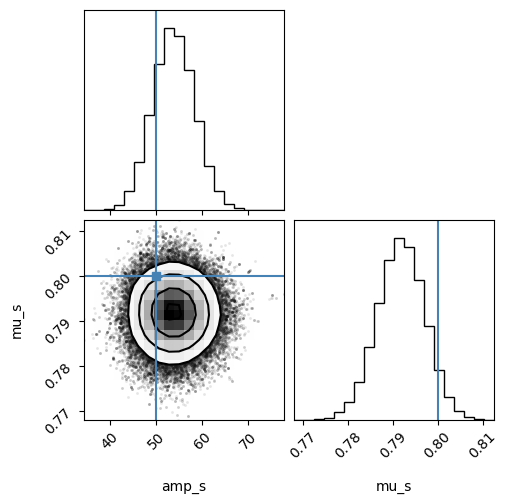

In [ ]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True) # throwing away the first 1000 steps of the chain ("burn-in") where it hasn't converged
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], smooth=1.);

# 3. Why Do We Need Simulation-Based Inference?

In many real-world applications such as in physics, biology, or economics, we don’t have an analytic form for the likelihood function. Instead:

* We have a **forward simulator** (a black-box function) that generates data given some theory parameters.
* We **can sample from $x \sim p(x \mid \theta)$**, but we can’t write down or evaluate the likelihood function.

Therefore, a variety of methods have been created to deal with the intractability of the likelihood function. These are collectively known as **simulation-based** or **likelihood-free inference**.

Classical SBI methods deal with this intracatability by constructing powerful summary statistics from samples generated by the simulator. This can be done by either creating a model for the likelihood by estimating the distribution of simulated data with for example **histograms** or by comparing the observed and simulated data based on some distance measure involving the summary statistics. The later is known as **Approximate Bayesian Computation (ABC)** and is one of the most well-known SBI methods.

While these methods are straightforward and efficient, they depend on the choice of the summary statistic and generally lead to information loss since we're reducing a high-dimensional phase space into one single observable. To overcome these limitations, modern SBI leverages machine learning, in particular neural networks to learn the likelihood or the posterior. Among the most widely used Neural Simulation-Based Inference techniques are:


- **Neural Posterior Estimation (NPE):** This approach trains a machine learning model to learn the posterior distribution directly from pairs of parameters and simulated observations.
  $$
  p(\theta \mid x)
  $$
Normalizing flows are commonly used as the underlying model

- **Neural Likelihood Estimation (NLE):** Rather than modeling the posterior directly, NLE focuses on approximating the likelihood:

  $$
  p(x \mid \theta)
  $$

  Once trained, standard inference techniques such as MCMC can be applied to obtain samples from the posterior.
  

- **Neural Ratio Estimation (NRE):** Instead of modeling the likelihood directly, NRE learns the likelihood ratio:

  $$
  r(x, \theta) = \frac{p(x \mid \theta_0)}{p(x \mid \theta_1)}
  $$

  This is done by training a classifier to tell apart two hypothesis (e.g data generated according to $\theta_0$ or $\theta_1$).


  These methods are particularly powerful because they scale well with complex, high-dimensional data and enable amortized inference, meaning they can be trained once and used repeatedly for different observations without retraining. However, they rely on accurate simulators and generating/training sufficiently large samples can be very expensive and time consuming.


# 4. SBI algorithms

We will use once again the **bump on power law** example to do inference without relying on the explicit likelihood evaluation. The key idea is that even though we can’t write down $p(x \mid \theta)$, we can sample from it. Each time we generate data from our simulator using a specific $\theta$, we’re effectively drawing a sample from the (unknown) likelihood:
$$x \sim p(x \mid \theta)$$

This is what makes the **likelihood implicit** — it’s not available in closed form, but it’s encoded in the simulator.

Let’s now define a simple bump-on-power-law simulator to illustrate this idea.

In [ ]:
def bump_simulator(thetas, y):
    """ Simulate samples from the bump on power law model given theta = (amp_s, mu_s) and points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    x_mu = bump_on_power_law(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

# Test it out
bump_simulator([50, 0.8], y)

array([151, 159, 155, 136, 142, 109, 109, 102, 111, 103, 102,  94, 107,
       106,  78,  91,  79,  89,  79,  77,  75,  57,  75,  56,  72,  80,
        67,  67,  63,  50,  50,  55,  64,  76,  82,  90,  96, 102, 116,
       103,  91,  80,  56,  58,  58,  68,  45,  37,  46,  32])

## 4.1 Template histograms

### Template Histograms in Particle Physics

The most common SBI method in particle physics is to estimate the probability density function by **filling histograms** (also known as **templates**) from Monte Carlo simulations. This is typically done by selecting one or two **summary observables** and generating histograms for several values of the parameter $\theta$.  These templates are then compared to observed data (which is also binned in the same way as the templates), and the likelihood is estimated by assuing that the bin counts follow independent Poission distributions:

$$
\log \mathcal{L}(\theta) = \sum_i \left( n_i \log \mu_i(\theta) - \mu_i(\theta) \right)
$$

Here,  $n_i $ is the number of events in bin $i $ and $\mu_i(\theta) $ is the expected number of events in tha bin for a given parameter value $\theta$, estimated from simulation.

This approach is used to extract best-fit parameters, perform hypothesis testing, and build confidence intervals.

Let's start by plotting multiple templates for different values of amp_s, while keeping mu_s = 0.8 (for visualization purposes).

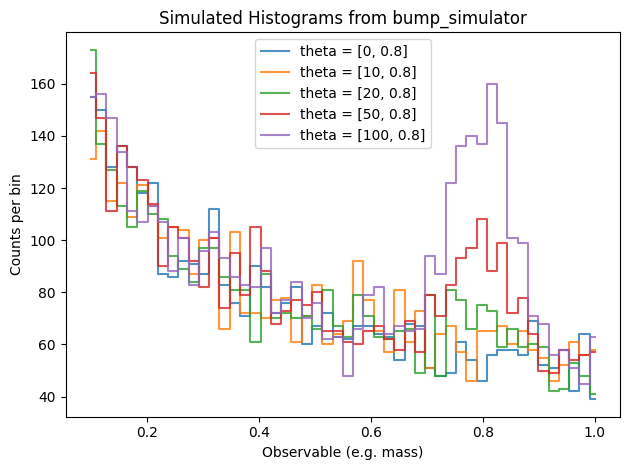

In [ ]:
amp_s_values = [0, 10, 20, 50, 100]


for amp in amp_s_values:
    theta = [amp, 0.8]
    sim_hist = bump_simulator(theta, y)
    plt.step(y, sim_hist, where='mid', label=f"theta = {theta}", alpha=0.8)

plt.xlabel("Observable (e.g. mass)")
plt.ylabel("Counts per bin")
plt.title("Simulated Histograms from bump_simulator")
plt.legend()
plt.tight_layout()
plt.show()

Now we can estimate the likelihood and perform a **maximum likelihood estimation (MLE)** by comparing the observed data to templates generated at different values of `amp_s`. For each value, we compute the Poisson log-likelihood based on the expected and observed bin counts. The parameter value that maximizes this likelihood is taken as the **best-fit estimate**.

We also compute the likelihood ratio:

$$
-2 \log \Lambda(\theta) = -2 \left[ \log \mathcal{L}(\theta) - \log \mathcal{L}(\hat{\theta}) \right]
$$

where $\hat{\theta}$ is the MLE. This statistic is commonly used to quantify how well each parameter value explains the data relative to the best fit and allows us to construct confidence intervals based on predefined thresholds.

Try out different values for n_sim and and amp_grid in the cell bellow and see how this affects the results!

Performing MLE and likelihood ratio scan...


Scanning amp_s: 100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


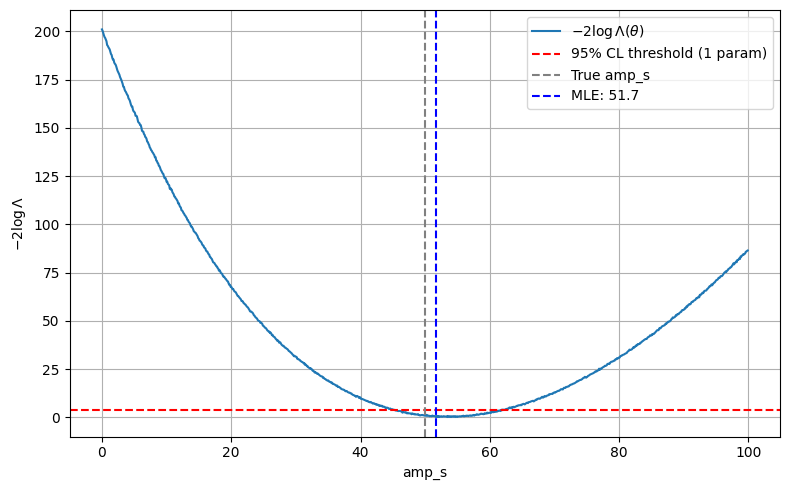

MLE estimate for amp_s: 51.7


In [ ]:
# Estimate expected bin counts by averaging over simulations
def estimate_mu(theta, y, n_sim=10000):
    sims = np.array([bump_simulator(theta, y) for _ in range(n_sim)])
    return sims.mean(axis=0)

# Compute Poisson log-likelihood between observed and expected histograms
def poisson_log_likelihood(n_obs, mu):
    mu = np.clip(mu, 1e-9, None)
    return np.sum(n_obs * np.log(mu) - mu)


# Scan over amp_s, fixing mu_s
amp_grid = np.arange(0, 100, 0.1)
log_likelihoods = []

print("Performing MLE and likelihood ratio scan...")

for amp_s in tqdm(amp_grid, desc="Scanning amp_s"):
    theta = [amp_s, 0.8]
    mu_est = estimate_mu(theta, y)
    logL = poisson_log_likelihood(x, mu_est)
    log_likelihoods.append(logL)

log_likelihoods = np.array(log_likelihoods)

# Compute likelihood ratio test statistic: -2 log(L(theta) / L_max)
logL_max = np.max(log_likelihoods)
likelihood_ratio = -2 * (log_likelihoods - logL_max)

# Extract MLE
mle_index = np.argmax(log_likelihoods)
mle_theta = amp_grid[mle_index]

# Plot likelihood ratio scan
plt.figure(figsize=(8, 5))
plt.plot(amp_grid, likelihood_ratio, label=r"$-2 \log \Lambda(\theta)$")
plt.axhline(3.84, color='red', linestyle='--', label='95% CL threshold (1 param)')
plt.axvline(50, color='gray', linestyle='--', label='True amp_s')
plt.axvline(mle_theta, color='blue', linestyle='--', label=f'MLE: {mle_theta:.1f}')
plt.xlabel("amp_s")
plt.ylabel(r"$-2 \log \Lambda$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"MLE estimate for amp_s: {mle_theta:.1f}")

## 4.2 Approximate Bayesian Computation (ABC)

"<img src="https://raw.githubusercontent.com/smsharma/sbi-lecture-mit/main/assets/abc.png" width="800">


Contrary to the histogram-based method—which can be viewed as a form of **approximate frequentist computation** — **ABC** is a Bayesian approach that directly produces posterior samples. The idea behind ABC is to generate samples from the forward model by drawing parameters $\theta$ from a prior and simulating corresponding data. These simulated data are then compared to the observed dataset $x$. If the two are sufficiently close according to some predefined criterion, the associated parameter values are accepted. In this case, the comparison is based on a simple **mean squared error (MSE)** between the data points. The resulting set of accepted parameter points forms an approximate posterior distribution.

In [ ]:
x_fwd = bump_simulator([50, 0.8], y) # simulated samples (x are the observed counts)

# Mean squared error
eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)
eps

np.float64(195.42)

In [ ]:
def abc(y, x, eps_thresh=500., n_samples=1000):
    """ABC algorithm for Gaussian bump model.

    Args:
        y (np.ndarray): Abscissa points.
        x (np.ndarray): Data counts.
        eps_thresh (float, optional): Acceptance threshold. Defaults to 500.0.
        n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.

    Returns:
        np.ndarray: Accepted samples approximating the posterior p(theta|x).
    """
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # Keep simulating until we have enough accepted samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])  # Priors; theta ~ p(theta)
        x_fwd = bump_simulator(params, y)  # x ~ p(x|theta)
        eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

n_samples = 5_000
post_samples = abc(y, x, eps_thresh=200, n_samples=n_samples)

Accepted Samples: 100%|██████████| 5000/5000 [01:25<00:00, 58.64samples/s, acceptance_ratio=0.005]


No we can compare the posterior samples from standard Bayesian inference using MCMC with an explicit likelihood (in red) and the posterior samples from the ABC method (in black):

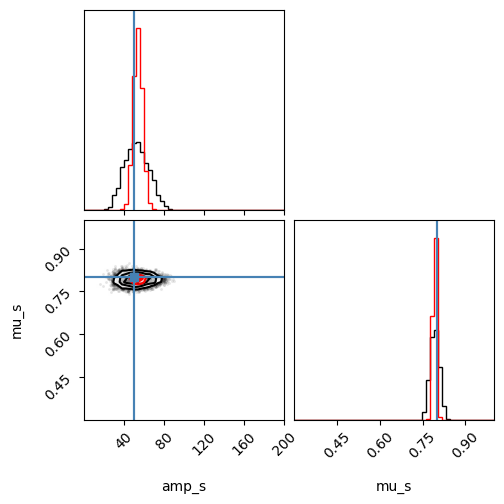

In [ ]:
# Plot posterior samples
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);

## 4.3 Neural likelihood-ratio estimation (NRE)

"<img src="https://raw.githubusercontent.com/smsharma/sbi-lecture-mit/main/assets/nre.png" width="800">


**NRE** is useful for **both frequentist** and **bayesian statistics**. In the first case, the goal is to **compare two specific hypothesis** (e.g. Null: $\theta = \theta_0$ = SM vs Alternate: $\theta = \theta_1$ = BSM). In this case the **likelihood ratio** is given by:

$$r(x|\theta) = \frac{p(x \mid \theta_0)}{p(x \mid \theta_1)}$$

In Bayesian statistics, we're not interested in testing between two fixed hypotheses, but rather **estimating the entire posterior**:

$$p(\theta \mid x) \propto \frac{p(x \mid \theta)}{p(x)} \cdot p(\theta)$$

To do that, we need to learn the **likelhood-to-evidence ratio**:

$$r(x, \theta) = \frac{p(x \mid \theta)}{p(x)} = \frac{p(x, \theta)}{p(x)p(\theta)}$$

that tell us: *For any $\theta$, how well does it explain $x$ compared to all other possible $\theta$’s drawn from the prior?*

In both scenarios, NRE reframes the problem of estimating a likelihood ratio as a **classification problem**, since the **decision funcion** modelled by a classifier can be converted into an estimator for the likelihood ratio:

$$\hat r(x, \theta) = \frac{s(x, \theta)}{1 - s(x, \theta)} $$

In this tutorial, we focus on the second approach, where the alternate hypothesis is not a fixed value $\theta_0$, but instead assumes that $x$ and $\theta$ are independent, i.e., drawn from the **product of their marginal distributions**:
$(x, \theta) \sim p(x)\,p(\theta)$

We reframe the problem as a binary classification task:
* Class 1: samples from the joint distribution $p(x, \theta)$
* Class 0: samples from the product of marginals $p(x)\,p(\theta)$

The classifier is trained to distinguish between these two. From this setup, we can estimate the likelihood-to-evidence ratio:

$$\hat r(x, \theta) = \frac{s(x, \theta)}{1 - s(x, \theta)} = \frac{p(x, \theta)}{p(x)p(\theta)} = \frac{p(x \mid \theta)}{p(x)}$$

Here, $s(x, \theta)$ is the output of the classifier (i.e., the predicted probability that a pair came from the **joint distribution**). The ratio $\hat r(x, \theta)$ can also be recovered from the classifier logit, the value before applying the sigmoid function.

So this trick lets us learn the likelihood ratio by learning to distinguish real from fake (uncorrelated) pairs.

**note:**  these classifiers are called **parametrized classifiers**, since instead of taking just the data x as input, they take both the data x and the parameters $\theta$. This allows the classifier to generalize over the entire parameter space.

Let's start by creating the training data:

In [ ]:
n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))  # p(theta)
x_samples = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples)]) # p(x|theta) -> p(x,theta)=p(x|theta)p(theta)

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

100%|██████████| 50000/50000 [00:02<00:00, 24564.89it/s]


We'll use a simple multi-layer perceptron (MLP) as our parametrized classifier:

In [ ]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create a fully connected Multi-Layer Perceptron (MLP).

    Args:
        input_dim (int): Dimension of the input features.
        hidden_dim (int): Number of units in each hidden layer.
        output_dim (int): Dimension of the output layer.
        layers (int): Number of hidden layers.
        activation (nn.Module): Activation function to use (default: GELU).

    Returns:
        nn.Sequential: The MLP model as a PyTorch sequential module.
    """

    # Start with input layer followed by activation
    seq = [nn.Linear(input_dim, hidden_dim), activation]

    # Add specified number of hidden layers (each with activation)
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]

    # Add the final output layer (no activation)
    seq += [nn.Linear(hidden_dim, output_dim)]

    # Return the full MLP as a sequential model
    return nn.Sequential(*seq)

We’ll now define a Neural Ratio Estimator class with a simple binary cross-entropy loss that discriminates between samples from the joint distribution $\{x, \theta\} \sim p(x\mid\theta)$ and those from a product of marginals $\{x, \theta\} \sim p(x)\,p(\theta)$. Samples from the latter are obtained by taking a batch of $(x, \theta)$ pairs sampled from the joint distribution $p(x, \theta)$ and then randomly shuffling the $x$’s within the batch, thereby breaking their correlation between x and its corresponding theta. This approximates samples from the product of marginals $p(x)\,p(\theta)$.

The classifier is trained to assign high scores to real (joint) pairs and low scores to fake (shuffled) pairs using the binary cross-entropy loss:

$$\mathcal{L} = - \sum_i \left[ y_i \log(p_i) + (1 - y_i)\log(1 - p_i) \right]$$

where:
* $y_i \in \{0, 1\}$ indicates whether a pair is from the joint or shuffled set,
* $p_i = s(x_i, \theta_i)$ is the classifier’s predicted probability that $(x_i, \theta_i)$ is a joint sample.


In [ ]:
class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier.
    """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        # Classifier takes both x and theta as input (parametrized classifier)
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        # Forward pass through the MLP classifier
        return self.classifier(x)

    def loss(self, x, theta):
        """Binary cross-entropy loss to distinguish between joint and marginal samples."""

        # Repeat each x twice to pair it with both real and shuffled theta
        x = x.repeat_interleave(2, dim=0)

        # Shuffle theta to create mismatched (independent) samples
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave real and shuffled theta values
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Create binary labels: 1 for joint samples, 0 for shuffled (independent) samples
        labels = torch.ones(x.shape[0], device=x.device)
        labels[1::2] = 0.0 # Set every second label (shuffled pair) to 0

        # Concatenate x and theta and compute classifier outputs
        logits = self(torch.cat([x, theta], dim=1))

        # Convert logits to probabilities
        probs = torch.sigmoid(logits).squeeze()

        # Compute binary cross-entropy loss
        return nn.BCELoss(reduction='none')(probs, labels)


    # Training
    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    # Validation
    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    # Optimizer configuration (Adam)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Evaluating the loss before training:

In [ ]:
# Evaluate loss; initially it should be around -log(0.5) = 0.693 -> the classifier is randomly initialized
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2) # define the model
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.6944, 0.6919, 0.6942, 0.6916, 0.6943, 0.6920, 0.6927, 0.6936, 0.6951,
        0.6907, 0.6944, 0.6920, 0.6944, 0.6918, 0.6945, 0.6917, 0.6945, 0.6917,
        0.6942, 0.6921, 0.6944, 0.6921, 0.6945, 0.6915, 0.6942, 0.6922, 0.6945,
        0.6919, 0.6947, 0.6917, 0.6931, 0.6930, 0.6959, 0.6904, 0.6941, 0.6923,
        0.6939, 0.6924, 0.6942, 0.6919, 0.6946, 0.6917, 0.6941, 0.6922, 0.6939,
        0.6925, 0.6941, 0.6922, 0.6943, 0.6917, 0.6945, 0.6920, 0.6945, 0.6919,
        0.6950, 0.6913, 0.6952, 0.6915, 0.6933, 0.6928, 0.6947, 0.6915, 0.6943,
        0.6920, 0.6946, 0.6917, 0.6937, 0.6924, 0.6944, 0.6917, 0.6943, 0.6918,
        0.6944, 0.6918, 0.6926, 0.6936, 0.6945, 0.6919, 0.6945, 0.6920, 0.6946,
        0.6918, 0.6936, 0.6929, 0.6944, 0.6919, 0.6945, 0.6919, 0.6968, 0.6896,
        0.6946, 0.6914, 0.6946, 0.6918, 0.6928, 0.6931, 0.6944, 0.6921, 0.6945,
        0.6924, 0.6944, 0.6918, 0.6936, 0.6926, 0.6950, 0.6912, 0.6947, 0.6918,
        0.6944, 0.6917, 0.6967, 0.6895, 

Instantiate dataloader and training:

In [ ]:
# Fraction of the dataset to use for validation
val_fraction = 0.1

# Number of samples per batch during training
batch_size = 128

# Compute how many samples go to validation
n_samples_val = int(val_fraction * len(x_samples))

# Wrap x_samples and theta_samples into a PyTorch dataset
dataset = TensorDataset(x_samples, theta_samples)

# Randomly split the full dataset into training and validation subsets
dataset_train, dataset_val = random_split(
    dataset,
    [len(x_samples) - n_samples_val, n_samples_val]
)

# Create a DataLoader for the training set
train_loader = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

# Create a DataLoader for the validation set
val_loader = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
trainer = pl.Trainer(max_epochs=20) # Train for 20 epochs
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 73.0 K | train
--------------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


The classifier logits are now an estimator for the likelihood ratio. We can write down a log-likelihood function and use it to sample from the corresponding posterior distribution, just like before.

In [ ]:
def log_like(theta, x):
    """
    Estimate the log-likelihood-to-evidence ratio log r(x, theta)
    using the trained classifier's output (logit).
    """

    # Convert inputs from NumPy arrays (or lists) to PyTorch tensors
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize x and theta using training-time statistics
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    # Ensure inputs are at least 1D tensors (for safety)
    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    # Concatenate x and theta as input to the classifier
    # Output is the classifier logit = log [ r(x, theta) ]
    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze().detach().item()


# Generate a test parameter point
theta_test = [90, 0.8]

# Simulate observed data x from the model at that theta
x_test = bump_simulator(theta_test, y)

# Evaluate the estimated log-likelihood-to-evidence ratio
log_like(theta_test, x_test)


5.200986385345459

In [ ]:
def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

Sample with `emcee`:

In [ ]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = result.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [01:37<00:00, 51.10it/s]


Plot approximate posterior:

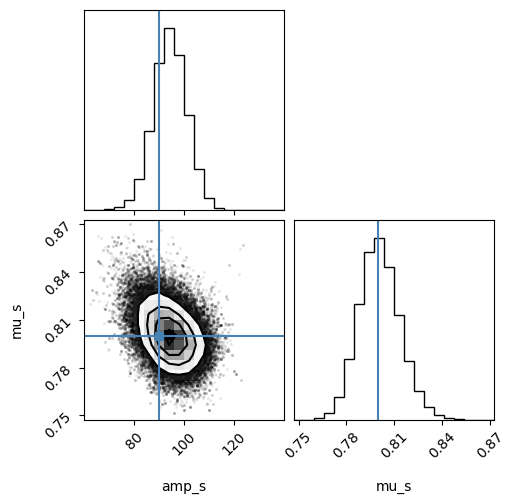

In [ ]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

## 4.4 Neural posterior estimation (NPE)

"<img src="https://raw.githubusercontent.com/smsharma/sbi-lecture-mit/main/assets/npe.png" width="800">


Now we'll construct a Neural Posterior Estimation (NPE) to learn directly the posterior distribution $ p(\theta \mid x) $.
To do this, we'll build a model with two parts.

The first part of the model is a **featurizer**, a small neural network (typically a multi-layer perceptron) that compresses the observed data $ x$  (that might be high-dimensional - e.g. a 50-bin histogram), into a **lower-dimensional context vector** $ s_\varphi(x) $. This featurizer is trained to extract only the information in $ x $ that is relevant for predicting $ \theta $, i.e., what aspectes of $x$ change when $\theta$ changes. The parameters of this network are denoted by $ \varphi $.

The second part is a **normalizing flow** — a flexible probabilistic model that learns to represent complex distributions by applying a sequence of invertible transformations to a simple distribution (e.g. a standard Gaussian). In our case, we want to learn $ p(\theta \mid x) $. In this example we use a **Masked Autoregressive Flow (MAF)**.

Each transformation in the flow is parameterized by a neural network that takes:

- The previously transformed components $ \theta_{<i} $,
- And the context $ s_\varphi(x) $.

The parameters of the flow (weights and biases of its internal networks) are denoted by $ \phi $.

The full model takes in a batch of $ (\theta, x) $ pairs (from simulation), and is trained using **maximum likelihood estimation**.

The loss function is the **negative log-probability of the true parameters under the learned posterior**:

$$
\mathcal{L} = -\log p_\phi(\theta \mid s_\varphi(x))
$$

This encourages the model to assign high probability to the true $ \theta $ that generated each simulated observation $ x $.

Both $ \varphi $ and $ \phi $ are trained simultaneously to minimize this loss over the training dataset.

To learn more about normalizing flows, see this [`paper`](https://arxiv.org/pdf/1912.02762).


In [ ]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

Creating the normalizing flow:

In [ ]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """
    Instantiate a simple Masked Autoregressive Flow (MAF) for modeling the posterior p(theta | x).

    Args:
        d_in (int): Dimensionality of the parameter space (theta).
        d_hidden (int): Number of hidden units in the neural nets inside each flow layer.
        d_context (int): Dimensionality of the context vector from the featurizer.
        n_layers (int): Number of autoregressive layers (i.e., how many transformations to stack).

    Returns:
        flow (Flow): A conditional normalizing flow model.
    """

    # Base distribution (normal distribution)
    base_dist = StandardNormal(shape=[d_in])

    # List of invertible transformations to apply in sequence
    transforms = []
    for _ in range(n_layers):
        # Add a permutation layer to break order dependencies across layers
        transforms.append(ReversePermutation(features=d_in))

        # Add a Masked Autoregressive Transform, conditioned on the context
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=d_in,               # dimension of theta
                hidden_features=d_hidden,   # width of the internal NN
                context_features=d_context  # dimension of the context vector s(x)
            )
        )

    # Compose all the transformations
    transform = CompositeTransform(transforms)

    # Wrap it into a flow: apply the transformation to the base distribution
    flow = Flow(transform, base_dist)

    return flow


# Instantiate the flow with default hyperparameters
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


Create the NPE class:

In [ ]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """
    A simple neural posterior estimator using a conditional normalizing flow (MAF)
    to model the posterior distribution p(theta | x).
    """
    def __init__(self, featurizer, d_context=16):
        super().__init__()

        # The featurizer maps x to a lower-dimensional context vector
        self.featurizer = featurizer

        # The flow models p(theta | context) using a Masked Autoregressive Flow
        self.flow = get_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        # Forward pass through the featurizer to get the context vector
        return self.featurizer(x)

    def loss(self, x, theta):
        # Compute the negative log-probability of theta under the learned posterior
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Instantiate the NPE class and look at the loss:

In [ ]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([4.6271, 4.9834, 5.0054, 5.0322, 4.6435, 4.9392, 4.8639, 4.4611, 4.5356,
        4.6742, 4.8247, 4.6755, 4.7594, 4.5136, 4.9198, 4.9461, 4.6235, 5.0169,
        4.7223, 5.0566, 4.6501, 4.8007, 5.0660, 4.6913, 4.4025, 4.8577, 4.8630,
        4.4545, 4.6877, 4.7752, 4.8698, 4.5630, 4.6536, 5.0882, 4.6252, 4.4318,
        4.9102, 4.8481, 4.8909, 4.9609, 5.0114, 4.8925, 4.6594, 4.6810, 4.7902,
        4.5260, 5.0896, 5.1895, 4.9493, 4.9835, 4.5581, 4.7566, 4.5671, 5.0263,
        4.7282, 4.7576, 4.5640, 4.7591, 4.8022, 4.5561, 4.7229, 4.9886, 4.4713,
        4.5763], grad_fn=<NegBackward0>)

Train using the same data as before:

In [ ]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | featurizer | Sequential | 74.6 K | train
1 | flow       | Flow       | 24.3 K | train
--------------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)
89        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Get a test data sample, pass it through the feature extractor, and condition the flow density estimator on it. We get posterior samples by drawing from
$$\theta \sim p_\phi(\theta\mid s_\varphi(x)).$$

In [ ]:
theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

In [ ]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

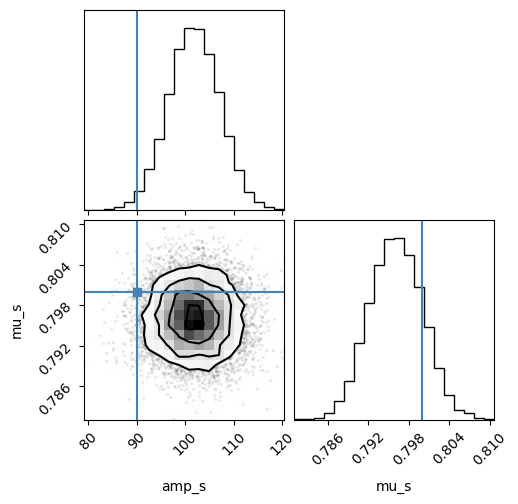

In [ ]:
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()
corner.corner(samples_test, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

# 5.References/ Further reading

- [The frontier of simulation-based inference](https://arxiv.org/abs/1911.01429) (Cranmer, Brehmer, Louppe): Review paper
- [simulation-based-inference.org](http://simulation-based-inference.org/): List of papers and resources
- [awesome-neural-sbi](https://github.com/smsharma/awesome-neural-sbi): List of papers and resources